<a href="https://colab.research.google.com/github/hyunjaec/MScA_Deep_Learning_Project/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import ndimage, signal as sg
from skimage import data, filters, io, color
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization, Input, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
!pwd

/content


In [3]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#label csv
austin_df = pd.read_csv("/content/drive/My Drive/Data/data/austin.csv")
austin_df = austin_df.drop('Unnamed: 0', axis = 1)
austin_df.head()

,image_name,zoning_id,zoning_zty
0,data/austin_0.jpg,229791,PUD
1,data/austin_1.jpg,229791,PUD
2,data/austin_2.jpg,400523442,I-RR
3,data/austin_3.jpg,229791,PUD
4,data/austin_4.jpg,229791,PUD


In [5]:
residential = ['LA',
            'RR',
            'SF-1',
            'SF-2',
            'SF-3',
            'SF-4A',
            'SF-4-A,'
            'SF-4B',
            'SF-5',
            'SF-6',
            'MF-1',
            'MF-2',
            'MF-3',
            'MF-4',
            'MF-5',
            'MF-6',
            'MF-CO',
            'MH']

commercial = ['NO',
            'LO',
            'GO',
            'CR',
            'LR',
            'GR',
            'L',
            'CBD',
            'DMU',
            'W/LO',
            'CS',
            'CS-1',
            'CH']

industrial = ['IP', 'LI', 'MI', 'R&D']

special = ['DR', 'AV', 'AG', 'P', 'PUD', 'TN', 'ERC', 'UNZ']

In [6]:
#loop through list of zone codes, map specific zone codes to R, C, I, or S
austin_df.loc[:, 'zone'] = np.nan

for i in residential:
    austin_df.loc[:, 'zone'] = np.where(austin_df.loc[:, 'zoning_zty'].str.contains(i) == True, 
                                     'R', austin_df.loc[:,'zone'])
for i in industrial:
    austin_df.loc[:, 'zone'] = np.where(((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & (austin_df.loc[:, 'zone'] != 'R')), 
                                     'I', austin_df.loc[:,'zone'])
for i in commercial:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'R') & (austin_df.loc[:, 'zone'] != 'I'), 
                                     'C', austin_df.loc[:,'zone'])
for i in special:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'I') & (austin_df.loc[:, 'zone'] != 'R') &\
                                     (austin_df.loc[:, 'zone'] != 'C'), 
                                     'S', austin_df.loc[:,'zone'])

In [7]:
#manually set this one
austin_df.loc[303, 'zone'] = 'R'

In [8]:
img_names = austin_df['image_name']

In [9]:
dim = (300, 300)
# img_df = []
# for i in img_names:
#   img_df.append(cv2.imread("/content/drive/My Drive/Data/" + str(i[:-4])+".jpg"))
img_df = []
# for i in img_names:
#     img_df.append(cv2.imread(('../'+ str(i))))
for i, img in enumerate(img_names):
    visual_img = image.load_img(('/content/drive/My Drive/Data/'+img), target_size=dim)
    img_array = image.img_to_array(visual_img)
    img_df.append(img_array)

In [10]:
#make images equal pixel by 500, 500 
# for i, img in enumerate(img_df):
#   img_df[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [11]:
zone_class = austin_df['zone']

In [12]:
zone_class = pd.factorize(zone_class)[0]
zone_class

array([0, 0, 1, ..., 0, 0, 0])

In [13]:
img_df2 = np.array(img_df) 
#split labels and images for train&test
X_train, X_test, y_train, y_test = train_test_split(img_df2, zone_class, test_size=.2)
input_shape = (300, 300, 3)

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


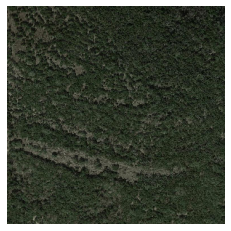

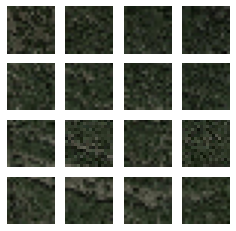

In [15]:
import matplotlib.pyplot as plt
image_size = 72  
patch_size = 16
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
import sys
sys.path.append('/content/sample_data/')

In [17]:
#!pip install tensorflow_addons

In [18]:
from vit_model import VisionTransformer

In [19]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [20]:
input_shape=X_train.shape[1:]
learning_rate = 0.001
weight_decay = 0.001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
projection_dim = 64
num_attention_heads = 4
num_transformer_layers = 8
num_mlp_heads = [2048, 1024]
output_classes = len(np.unique(y_train))

In [21]:
transformer = VisionTransformer(
    input_shape=input_shape, 
    image_size=image_size, 
    patch_size=patch_size, 
    projection_dim=projection_dim, 
    num_transformer_layers=num_transformer_layers,
    num_attention_heads=num_attention_heads,
    num_mlp_heads=num_mlp_heads,
    output_classes=output_classes
    )

In [22]:
def train(model, X_train, y_train, batch_size, epochs, learning_rate, weight_decay):
    model.summary()

    model.compile(learning_rate=learning_rate, weight_decay=weight_decay)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

    return model

In [23]:
trained_transformer = train(transformer, X_train, y_train, batch_size, num_epochs, learning_rate, weight_decay)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 72, 72, 3)    0           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['resizing[0][0]']               
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']          

In [26]:
score = trained_transformer.evaluate(X_test, y_test)
print('Test loss:', score)

23/23 [==============================] - 1s 33ms/step - loss: 1.6985 - accuracy: 0.5586 - top-5-accuracy: 1.0000
Test loss: [1.6985048055648804, 0.5585830807685852, 1.0]
